# 2. **Data Preprocessing**

Based on the data exploration, we will perform the the preprocessing phase.


In [1]:
# Install dependencies
%pip install -q -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# Set the style of the plots
palette = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)
bi_palette = "ch:s=.25,rot=-.25"

# paths
RES_DIR = os.path.join('..', 'resources')
IMG_DIR = os.path.join("..", "results", "preprocessing", "imgs")
CSV_DIR = os.path.join("..", "results", "preprocessing", "csv")
os.makedirs(RES_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

# raw data
RAW_DS_NAME = 'data_rf2_tidy.csv'

In [3]:
# Load the data
df = pd.read_csv(os.path.join(RES_DIR, RAW_DS_NAME), index_col=0).drop(columns=['set'])

## 2.1 Non-informative features

We remove the columns with only missing values:

In [4]:
# Remove columns with only missing values
init_len = len(df.columns)

filtered_mc_df = df.dropna(axis=1, how='all')
filtered_mc_len = len(filtered_mc_df.columns)

print(f"Removed {init_len - filtered_mc_len} columns with only missing values")

Removed 5 columns with only missing values


There are also columns with no variance:

In [5]:
# Remove columns with only one value
filtered_nv_df = filtered_mc_df.loc[:, filtered_mc_df.nunique() > 1]
filtered_nv_len = len(filtered_nv_df.columns)

print(f"Removed {filtered_mc_len - filtered_nv_len} columns with no variance")

Removed 1 columns with no variance


Then we also remove categorical features we are not interested in: 

In [6]:
filtered_nv_df.columns

Index(['datum', 'station_code', 'sector_id', 'dangerLevel', 'elevation_th',
       'warnreg', 'elevation_station', 'Qs', 'Ql', 'TSG', 'Qg0', 'Qr', 'OLWR',
       'ILWR', 'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h',
       'ISWR_diff', 'ISWR_dir', 'TA', 'TSS_mod', 'TSS_meas', 'T_bottom', 'RH',
       'VW', 'VW_drift', 'DW', 'MS_Snow', 'HS_mod', 'HS_meas', 'hoar_size',
       'wind_trans24', 'wind_trans24_7d', 'wind_trans24_3d', 'HN24', 'HN72_24',
       'HN24_7d', 'SWE', 'MS_water', 'MS_Wind', 'MS_Rain', 'MS_SN_Runoff',
       'MS_Sublimation', 'MS_Evap', 'TS0', 'TS1', 'TS2', 'Sclass2', 'zSd_mean',
       'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4', 'S5', 'pwl_100',
       'pwl_100_15', 'base_pwl', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl',
       'ssi_pwl_100', 'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100',
       'Pen_depth', 'min_ccl_pen'],
      dtype='object')

We decided to remove:
- `station_code`, `sector_id`, `warnreg`, `elevation_station`: location bias;
- `elevation_th`: direct leakage, part of the bulletin.

`datum` will be used for fold creation and then dropped.

In [7]:
# Remove other useless columns
cols_to_drop = ['station_code', 'sector_id', 'warnreg', 'elevation_th', 'elevation_station']
filtered_df = filtered_nv_df.drop(columns=cols_to_drop)

## 2.2 Missing values

As we already observed, 22.87% of dataset's tuples have at least one missing value. 

**Samples with missing values are removed** rather than imputed to ensure data quality and consistency. As noted in Pérez-Guillén et al. (2022), meteorological inputs were already preprocessed with interpolation; residual missing values likely indicate problematic cases. Imputation could introduce noise or physically inconsistent artifacts, so deletion was preferred to preserve model reliability.


In [8]:
# Remove tuples with missing values
reduced_df = filtered_df.dropna(how='any')
print(f"Rows with missing values removed: {df.shape[0] - reduced_df.shape[0]:,}\nRemaining rows: {reduced_df.shape[0]:,}")

Rows with missing values removed: 6,695
Remaining rows: 22,601


How target variable distribution changes after removing missing values:

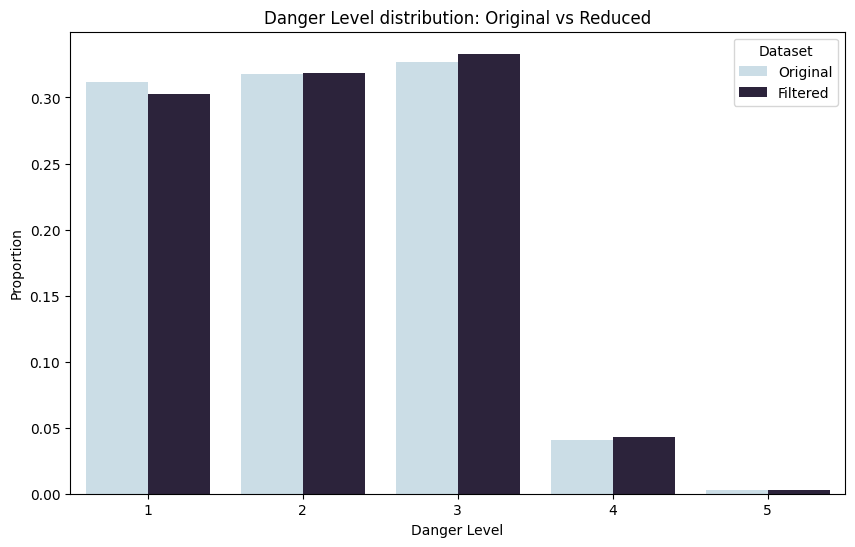

In [9]:
# Class distribution
distribution_df = pd.DataFrame({
        'Original': df['dangerLevel'].value_counts(normalize=True).sort_index(),
        'Filtered': reduced_df['dangerLevel'].value_counts(normalize=True).sort_index()
    },
    index = sorted(df['dangerLevel'].unique())
)

melted_df = distribution_df.reset_index().melt(id_vars='index', value_vars=['Original', 'Filtered'], 
                                               var_name='Dataset', value_name='Count')
melted_df = melted_df.rename(columns={'index': 'dangerLevel'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted_df, x='dangerLevel', y='Count', hue='Dataset', palette=bi_palette)
plt.title('Danger Level distribution: Original vs Reduced')
plt.xlabel('Danger Level')
plt.ylabel('Proportion')
plt.savefig(os.path.join(IMG_DIR, 'danger_level_distribution.png'), dpi=300)
plt.show()


As we can observe, removing tuples with missing values **does not affect significantly** the distribution of the target variable.

Let's have a look to the other features:

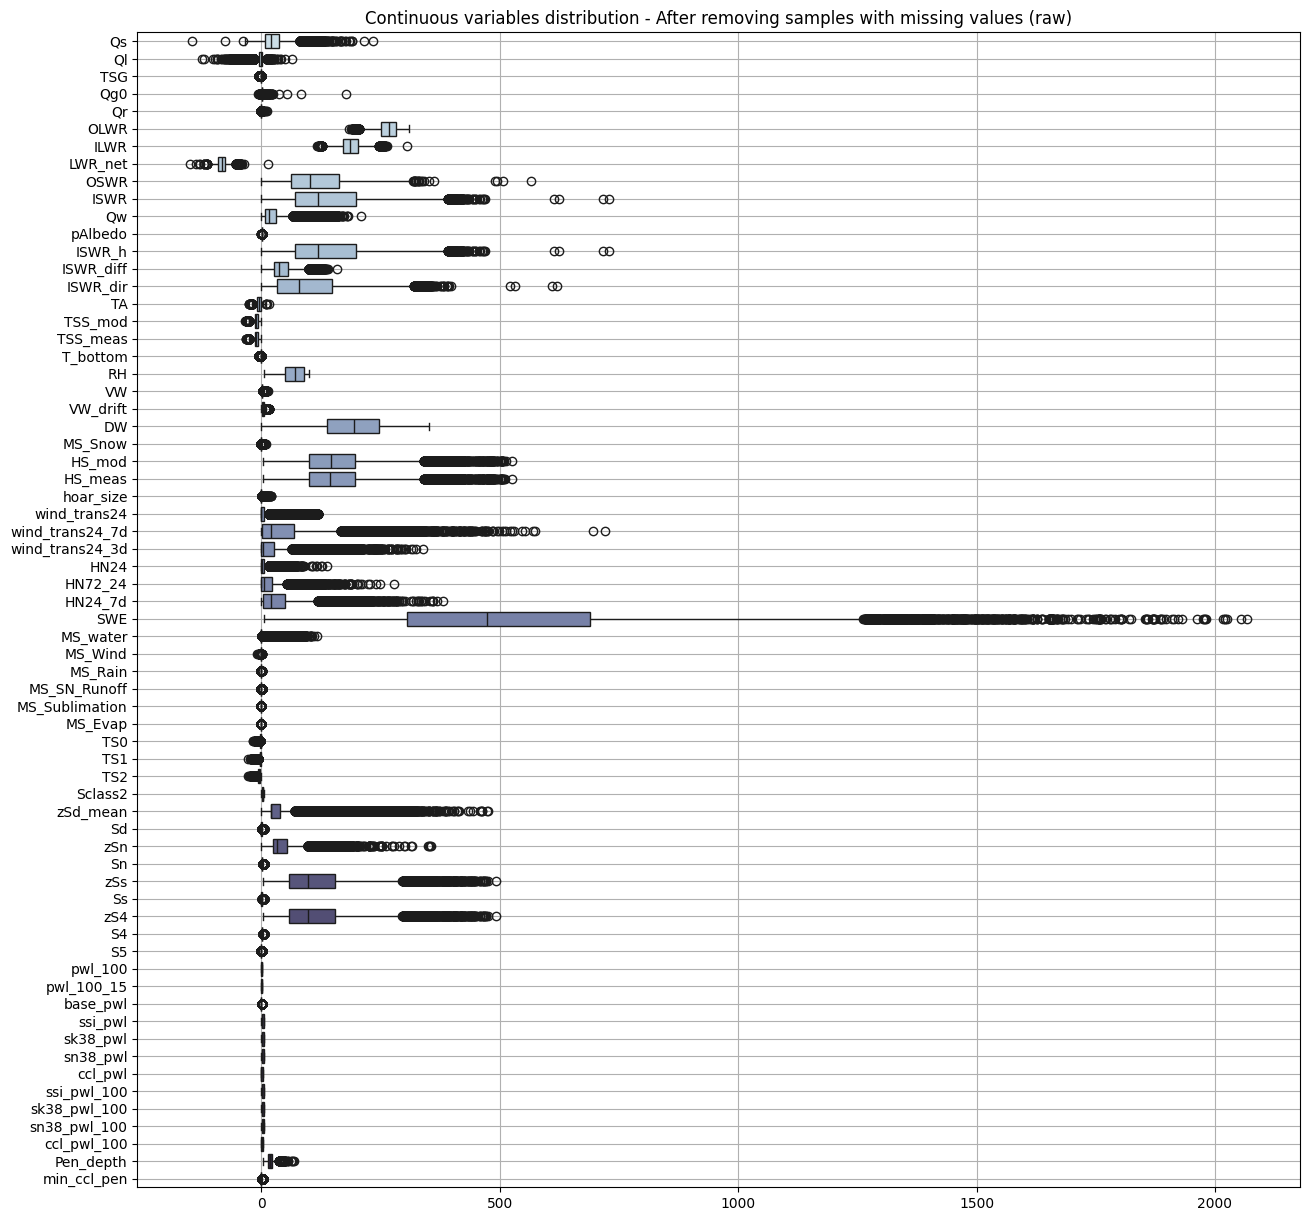

In [15]:
# Raw distributions
numeric_df = reduced_df.select_dtypes(include=['float64'])

plt.figure(figsize=(15, 15))
sns.boxplot(data=numeric_df, orient='h', palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(numeric_df.columns)))
plt.xticks(rotation=0)
plt.title('Continuous variables distribution - After removing samples with missing values (raw)')
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'continuous_variables_distribution_raw.png'), bbox_inches='tight')
plt.show()

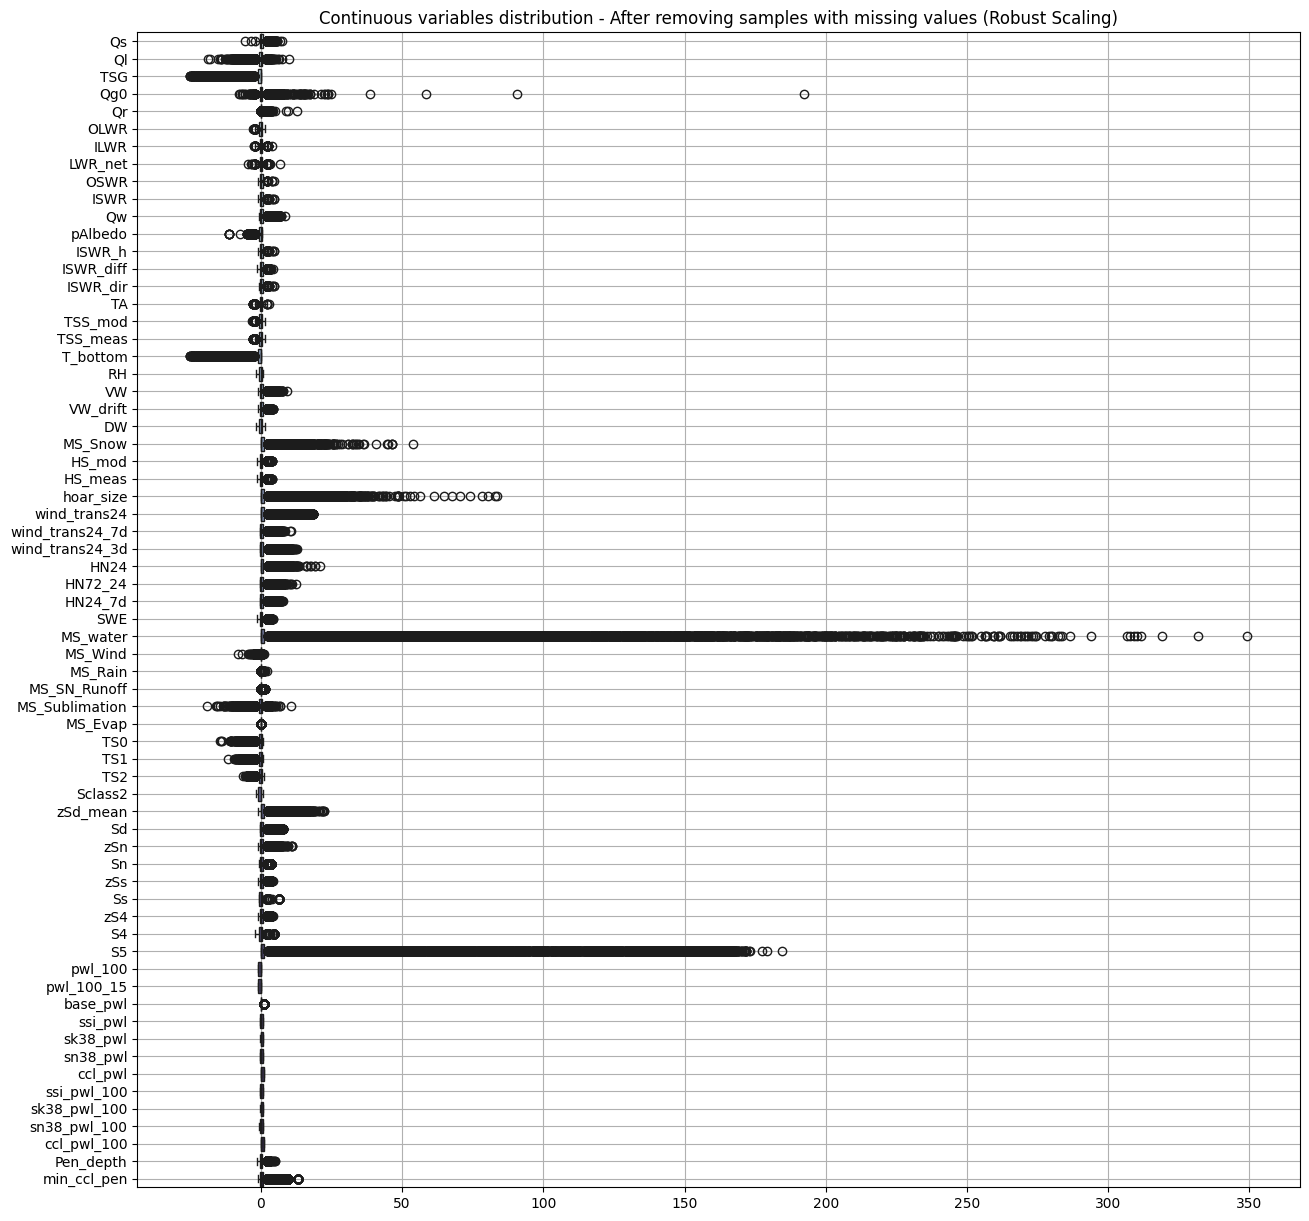

In [12]:
# Robust scaling
scaler = RobustScaler()
scaled_numeric_df = scaler.fit_transform(numeric_df)
scaled_numeric_df = pd.DataFrame(scaled_numeric_df, columns=numeric_df.columns)

plt.figure(figsize=(15, 15))
sns.boxplot(data=scaled_numeric_df, orient='h', palette=sns.color_palette("ch:s=.25,rot=-.25", n_colors=filtered_df.select_dtypes(include=['float64']).shape[1]))
plt.xticks(rotation=0)
plt.title('Continuous variables distribution - After removing samples with missing values (Robust Scaling)')
plt.grid(True)
plt.savefig(os.path.join(IMG_DIR, 'continuous_variables_distribution_robust_scaled.png'), dpi=300)
plt.show()

Observing the new raw distribution, removing tuples with missing values also removed some extreme values of certain features, but the distribution using Robust Scaler is still similar to the original one.

## 2.4 Save the dataset

In [11]:
reduced_df.to_csv(os.path.join(RES_DIR, f'reduced_{RAW_DS_NAME}'), index=False)